In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [36]:
weather = pd.read_csv('../data/processed/merged_cleaned_weather_data.csv')
weather['DATE']=pd.to_datetime(weather['DATE'])
weather['year'] = weather['DATE'].dt.year
weather['month'] = weather['DATE'].dt.month
weather['day'] = weather['DATE'].dt.day
weather['hour'] = weather['DATE'].dt.hour
weather.drop(columns=["REPORT_TYPE", "DATE"], inplace=True)
print(weather.head())

   wind_speed_raw  wind_dir_sin  wind_dir_cos  ceiling_coverage  visibility_m  \
0            28.0     -0.866025     -0.500000               0.0        6000.0   
1            30.5     -0.642788     -0.766044               0.0        6000.0   
2            35.5     -0.571394     -0.816035               0.0        6000.0   
3            25.5     -0.704416     -0.704416               0.0        5000.0   
4            28.0     -0.571394     -0.816035               0.0        5000.0   

   temperature_C  SLP_hpa  DEW_C  MA1_main  MA1_sec  GA1_amt  GA1_height  \
0           0.05   1030.2  -0.95   10280.0   9996.0      4.5       720.0   
1           0.90   1029.9  -0.90   10280.0   9994.0      7.0       705.0   
2           0.90   1028.6  -1.00   10270.0   9981.0      5.0       750.5   
3          -0.90   1027.3  -1.90   10250.0   9967.0      NaN         NaN   
4          -1.00   1026.3  -2.15   10240.0   9957.0      NaN         NaN   

   GA1_type  MD1_m1  MD1_m2  year  month  day  hour  
0 

In [37]:
air_quality = pd.read_csv('../data/processed/air_quality_2019_2023_long.csv')
print(air_quality.head())

   year  month  day  weekday  hour  day_of_year  hour_sin  hour_cos   doy_sin  \
0  2019      1    1        1     1            1  0.258819  0.965926  0.017202   
1  2019      1    1        1     2            1  0.500000  0.866025  0.017202   
2  2019      1    1        1     3            1  0.707107  0.707107  0.017202   
3  2019      1    1        1     4            1  0.866025  0.500000  0.017202   
4  2019      1    1        1     5            1  0.965926  0.258819  0.017202   

    doy_cos  weekday_sin  weekday_cos  station_code     pm10  
0  0.999852     0.781831      0.62349  MpKrakAlKras  88.2185  
1  0.999852     0.781831      0.62349  MpKrakAlKras  95.2209  
2  0.999852     0.781831      0.62349  MpKrakAlKras  85.3689  
3  0.999852     0.781831      0.62349  MpKrakAlKras  70.8575  
4  0.999852     0.781831      0.62349  MpKrakAlKras  50.1935  


In [86]:
merged_df = pd.merge(
    air_quality,
    weather,
    on=["year", "month", "day", "hour"],
    how="left"
)


print(merged_df.head())
print(merged_df.shape)


   year  month  day  weekday  hour  day_of_year  hour_sin  hour_cos   doy_sin  \
0  2019      1    1        1     1            1  0.258819  0.965926  0.017202   
1  2019      1    1        1     2            1  0.500000  0.866025  0.017202   
2  2019      1    1        1     3            1  0.707107  0.707107  0.017202   
3  2019      1    1        1     4            1  0.866025  0.500000  0.017202   
4  2019      1    1        1     5            1  0.965926  0.258819  0.017202   

    doy_cos  ...  temperature_C  SLP_hpa DEW_C  MA1_main  MA1_sec  GA1_amt  \
0  0.999852  ...           0.90   1029.9 -0.90   10280.0   9994.0      7.0   
1  0.999852  ...           0.90   1028.6 -1.00   10270.0   9981.0      5.0   
2  0.999852  ...          -0.90   1027.3 -1.90   10250.0   9967.0      NaN   
3  0.999852  ...          -1.00   1026.3 -2.15   10240.0   9957.0      NaN   
4  0.999852  ...          -0.65   1025.0 -1.70   10230.0   9945.0      5.5   

   GA1_height  GA1_type  MD1_m1  MD1_m2  
0 

In [87]:
merged_df.isna().sum()

year                     0
month                    0
day                      0
weekday                  0
hour                     0
day_of_year              0
hour_sin                 0
hour_cos                 0
doy_sin                  0
doy_cos                  0
weekday_sin              0
weekday_cos              0
station_code             0
pm10                     0
wind_speed_raw        1826
wind_dir_sin         26893
wind_dir_cos         26893
ceiling_coverage      2128
visibility_m          2314
temperature_C         1724
SLP_hpa               2815
DEW_C                 1717
MA1_main              2932
MA1_sec               2633
GA1_amt              66754
GA1_height          106325
GA1_type             37176
MD1_m1               18704
MD1_m2                2500
dtype: int64

In [88]:
merged_df.drop(columns=["GA1_height", "GA1_amt", "GA1_type", "weekday", "day_of_year"], inplace=True)

In [89]:
merged_df.dropna()
stations = ["MpKrakAlKras", "MpKrakBujaka", "MpKrakBulwar", "MpKrakOsPias", "MpKrakSwoszo", "MpKrakWadow", "MpKrakZloRog"]
stations_df = []
for station in stations:
    stations_df.append(merged_df.loc[merged_df['station_code'] == station])


In [90]:
cat_columns = ["month", "station_code"]

In [93]:
from catboost import CatBoostRegressor

for station in stations_df:
    X_full = station.drop(columns=['pm10'])
    y = pd.to_numeric(station["pm10"])

    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=0.2, random_state=42
    )

    cat_features = [X_train.columns.get_loc(col) for col in cat_columns]
    
    catboost = CatBoostRegressor(cat_features=cat_features, verbose=0, random_state=42)
    catboost.fit(X_train, y_train)
    
    y_pred_cat = catboost.predict(X_test)
    mse_cat = mean_squared_error(y_test, y_pred_cat)
    print(f"{station["station_code"].head(1)} CatBoost MSE: {mse_cat:.2f}")

0    MpKrakAlKras
Name: station_code, dtype: object CatBoost MSE: 176.32
34604    MpKrakBujaka
Name: station_code, dtype: object CatBoost MSE: 139.62
77515    MpKrakBulwar
Name: station_code, dtype: object CatBoost MSE: 144.58
120588    MpKrakOsPias
Name: station_code, dtype: object CatBoost MSE: 106.56
161920    MpKrakSwoszo
Name: station_code, dtype: object CatBoost MSE: 103.37
204379    MpKrakWadow
Name: station_code, dtype: object CatBoost MSE: 102.87
247796    MpKrakZloRog
Name: station_code, dtype: object CatBoost MSE: 110.89


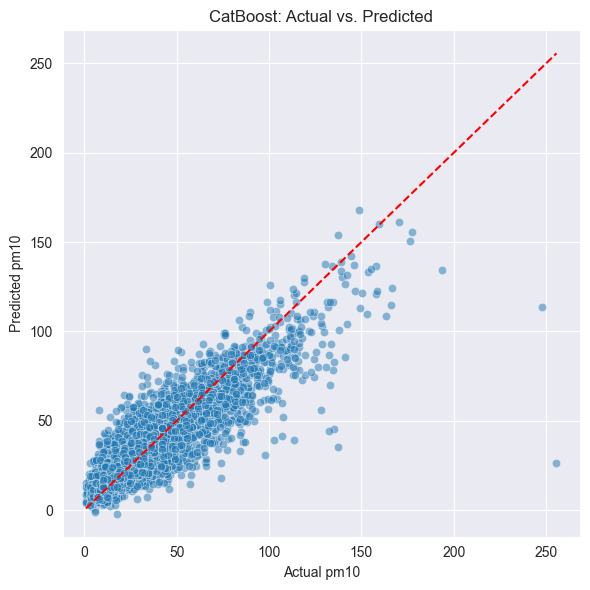

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(y_true, y_pred, title="Actual vs. Predicted"):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Actual pm10")
    plt.ylabel("Predicted pm10")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example for CatBoost
plot_predictions(y_test, y_pred_cat, title="CatBoost: Actual vs. Predicted")